### Uso de Red Neuronal para trabajar Series de Tiempo

In [2]:
%pip install tensorflow

Note: you may need to restart the kernel to use updated packages.Collecting tensorflow
  Using cached tensorflow-2.13.0-cp39-cp39-win_amd64.whl (1.9 kB)
  Using cached tensorflow_intel-2.13.0-cp39-cp39-win_amd64.whl (276.5 MB)
  Using cached grpcio-1.57.0-cp39-cp39-win_amd64.whl (4.3 MB)
  Using cached wrapt-1.15.0-cp39-cp39-win_amd64.whl (36 kB)
  Using cached tensorflow_estimator-2.13.0-py2.py3-none-any.whl (440 kB)
  Using cached keras-2.13.1-py3-none-any.whl (1.7 MB)
  Using cached absl_py-1.4.0-py3-none-any.whl (126 kB)
  Using cached tensorflow_io_gcs_filesystem-0.31.0-cp39-cp39-win_amd64.whl (1.5 MB)
  Using cached typing_extensions-4.5.0-py3-none-any.whl (27 kB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl (12 kB)
  Using cached tensorboard-2.13.0-py3-none-any.whl (5.6 MB)
  Using cached termcolor-2.3.0-py3-none-any.whl (6.9 kB)
  Using cached google_pasta-0.2.0-py3-none-any.whl (57 kB)
  Using cached libclang-16.0.6-py2.py3-none-win_amd64.whl (24.4 MB)
  Using cached h

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
You should consider upgrading via the 'c:\Users\Alien Ware\AppData\Local\Programs\Python\Python39\python.exe -m pip install --upgrade pip' command.


In [4]:
from math import sqrt
from numpy import array
from numpy import mean
from numpy import std
from pandas import DataFrame
from pandas import concat
from pandas import read_csv
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from matplotlib import pyplot
%matplotlib inline  
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Funciones

In [5]:
# split a univariate dataset into train/test sets
def division_entreno_prueba(datos, n_prueba):
    return datos[:-n_prueba], datos[-n_prueba:]

Para la entrada de datos, a la red, es necesario transformarlos de una lista o serie, a un formato adecuado para el aprendizaje supervisado

In [6]:
def series_a_supervisado(datos, n_entrada, n_salida = 1):
	df = DataFrame(datos)
	cols = []
	# secuencia de entrada (t-n, ... t-1)
	for i in range(n_entrada, 0, -1):
		cols.append(df.shift(i))
	# secuencia predicha (t, t+1, ... t+n)
	for i in range(0, n_salida):
		cols.append(df.shift(-i))
	# juntarlo todo
	agg = concat(cols, axis = 1)
	# botar columnas con valores NaN
	agg.dropna(inplace = True)
	return agg.values

Obtener el valor de la raiz cuadrada de la media de los errores al cuadrado RMSE

In [7]:
def medir_rmse(actual, predicho):
	return sqrt(mean_squared_error(actual, predicho))

Ajustar los datos al modelo

In [8]:
def ajustar_modelo(entreno, config):
	# desempacar la configuración
	n_entrada, n_nodos, n_epocas, n_tandas = config
    #[24, 500, 100, 100]
    # preparar los datos
	datos = series_a_supervisado(entreno, n_entrada)
	entreno_x, entreno_y = datos[:, :-1], datos[:, -1]
	# definir el modelo
	modelo = tf.keras.Sequential()
	modelo.add(tf.keras.layers.Dense(n_nodos, activation='relu', input_dim = n_entrada))
	modelo.add(tf.keras.layers.Dense(1))
	modelo.compile(loss='mse', optimizer='adam')
	# ajustar
	modelo.fit(entreno_x, entreno_y, epochs = n_epocas, batch_size = n_tandas, verbose = 0)
	return modelo

Predecir con un modelo ya ajustado

In [9]:
def prediccion_modelo(modelo, historia, config):
	# desempacar la configuración
	n_entrada, _, _, _ = config
	# preparar los datos
	x_entrada = array(historia[-n_entrada:]).reshape(1, n_entrada)
	# predecir
	yhat = modelo.predict(x_entrada, verbose = 0)
	return yhat[0]

Validación hacia el frente para datos unviariados

In [10]:
def validacion_al_frente(datos, n_prueba, cfg):
    predicciones = []
    # dividir el conjunto de datos
    entreno, prueba = division_entreno_prueba(datos, n_prueba)
    # ajustar el modelo
    modelo = ajustar_modelo(entreno, cfg)
    # grabar la historia con el conjunto de datos de entrenamiento
    historia = [x for x in entreno]
    # pasar por cada incremento de tiempo en el conjunto de prueba
    for i in range(len(prueba)):
        # ajustar el modelo a los datos y predecir los datos históricos
        yhat = prediccion_modelo(modelo, historia, cfg)
        # agregar el dato predicho en la lista de preducciones
        predicciones.append(yhat)
        # agregar la observación a la historia para la siguiente iteración
        historia.append(prueba[i])
    # estimar el error de las predicciones
    error = medir_rmse(prueba, predicciones)
    print(f' > {error:.3f}')
    return [error, predicciones]

Evaluación iterativa de una configuraciñon

In [11]:
 def evaluacion_iter(datos, config, n_prueba, n_repeticiones = 5):
	# ajustar y evaluar el modelo n veces
    resultados = []
    predicciones = []
    for _ in range(n_repeticiones):
        resultados_temp, predicciones_temp = validacion_al_frente(datos, n_prueba, config)
        resultados.append(resultados_temp)
        predicciones.append(predicciones_temp)
    return [resultados, predicciones]

Resumir el rendimiento del modelo

In [12]:
def resumir_resultados(nombre, resultados):
	# imprimir un resúmen
	media_result, std_result = mean(resultados), std(resultados)
	print(f'{nombre}: {media_result:.3f} RMSE (+/- {std_result:.3f})')
	# gráficas de caja y bigotes
	pyplot.boxplot(resultados)
	pyplot.show()

Encontrar la mejor solución

In [13]:
def buscar_mejor_solucion(series, nombre, metodo = "red neuronal"):
    datos = series.values
    n_prueba = int(len(datos)*0.2) # porcentaje utilizado para prueba
    config = [24, 500, 100, 100]
    resultados, predicciones = evaluacion_iter(datos, config, n_prueba)
    resumir_resultados('mlp', resultados)
    plt.savefig("resultados_{nombre}_{metodo}.png")
    plt.show()
    entreno, prueba = division_entreno_prueba(datos,n_prueba)
    prediccion = pd.DataFrame(list(entreno.flatten()) + np.array(predicciones[0]).flatten().tolist())
    ax = pd.DataFrame(datos).plot(label="Original") # datos originales
    prediccion.plot(ax=ax, alpha=.7, figsize=(14,7))
    plt.savefig("pred_{nombre}_{metodo}.png")
    plt.show()

# Nacimiento Niñas

 > 6.803
 > 7.045
 > 6.922
 > 6.673
 > 6.861
mlp: 6.861 RMSE (+/- 0.124)


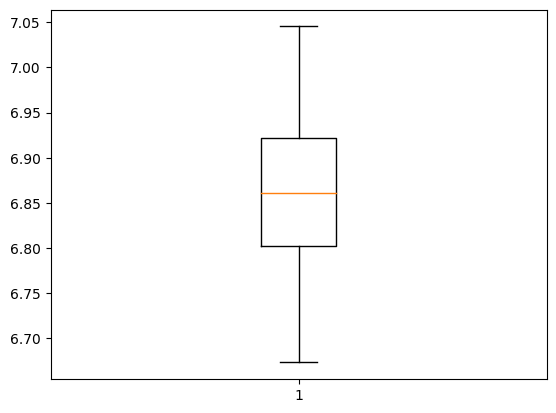

<Figure size 640x480 with 0 Axes>

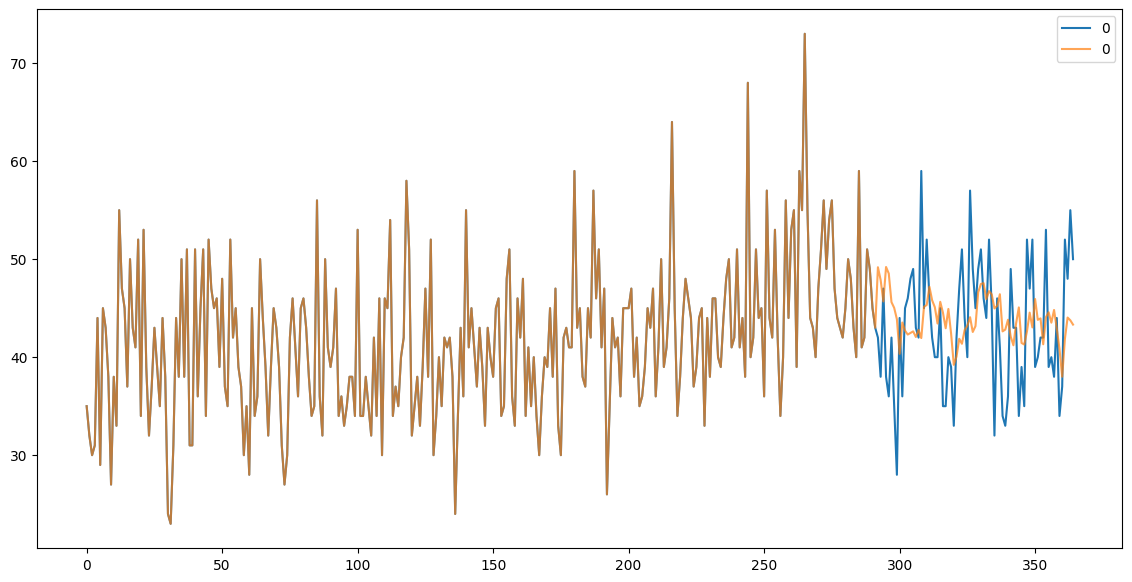

In [14]:
series = pd.read_csv('daily-total-female-births.csv', header=0,index_col=0)
buscar_mejor_solucion(series,"nacimientos")

# Ventas Shampoo

 > 108.182
 > 100.802
 > 111.865
 > 116.453
 > 106.806
mlp: 108.822 RMSE (+/- 5.221)


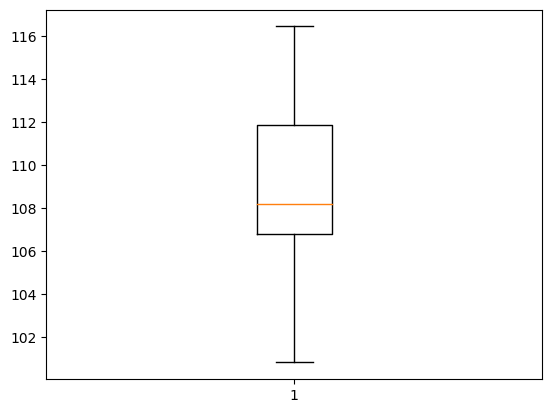

<Figure size 640x480 with 0 Axes>

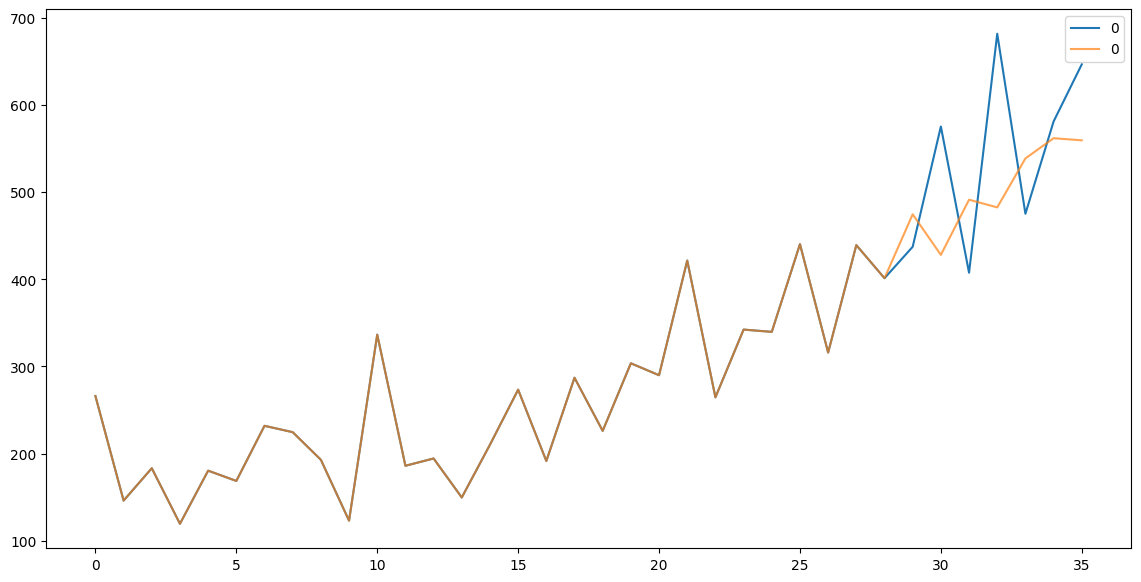

In [15]:
series = pd.read_csv('shampoo.csv', header=0, index_col=0)
buscar_mejor_solucion(series,"shampoo")

# Temperaturas

 > 2.292
 > 2.103
 > 2.283
 > 2.268
 > 2.053
mlp: 2.200 RMSE (+/- 0.101)


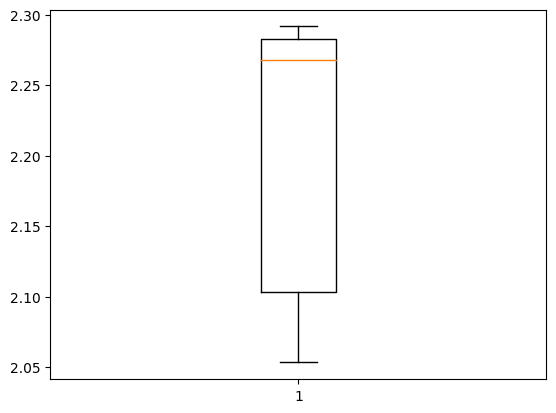

<Figure size 640x480 with 0 Axes>

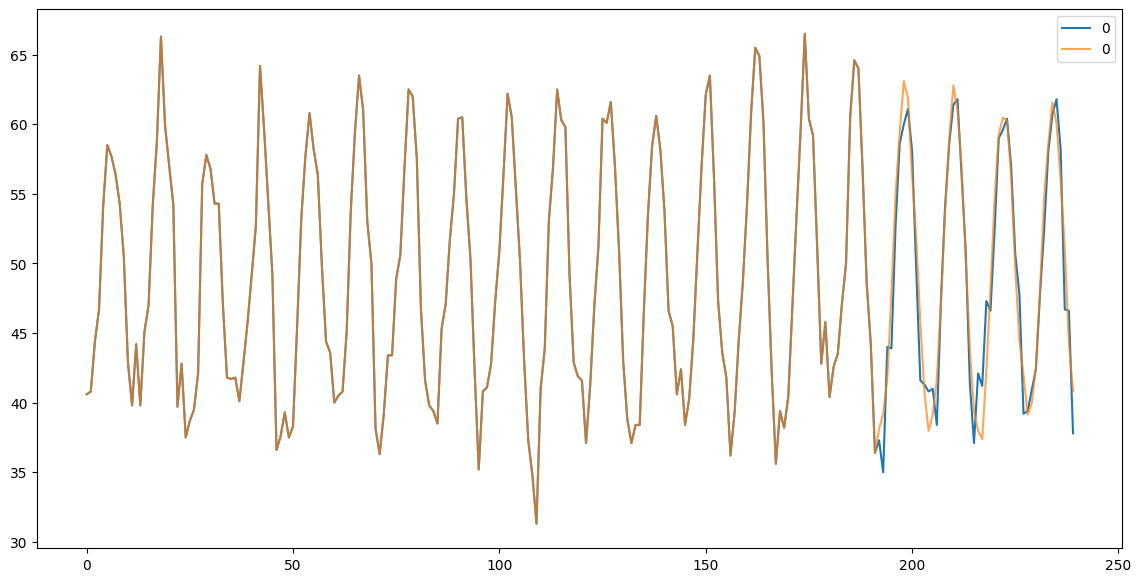

In [16]:
series = pd.read_csv('monthly-mean-temp.csv', header=0,parse_dates=["Month"],index_col=0)
buscar_mejor_solucion(series,"temp")

# Venta de carros

 > 2025.056
 > 1984.540
 > 1981.153
 > 1937.104
 > 1937.549
mlp: 1973.080 RMSE (+/- 33.029)


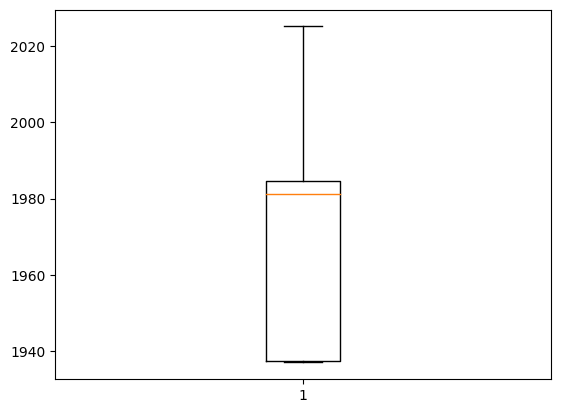

<Figure size 640x480 with 0 Axes>

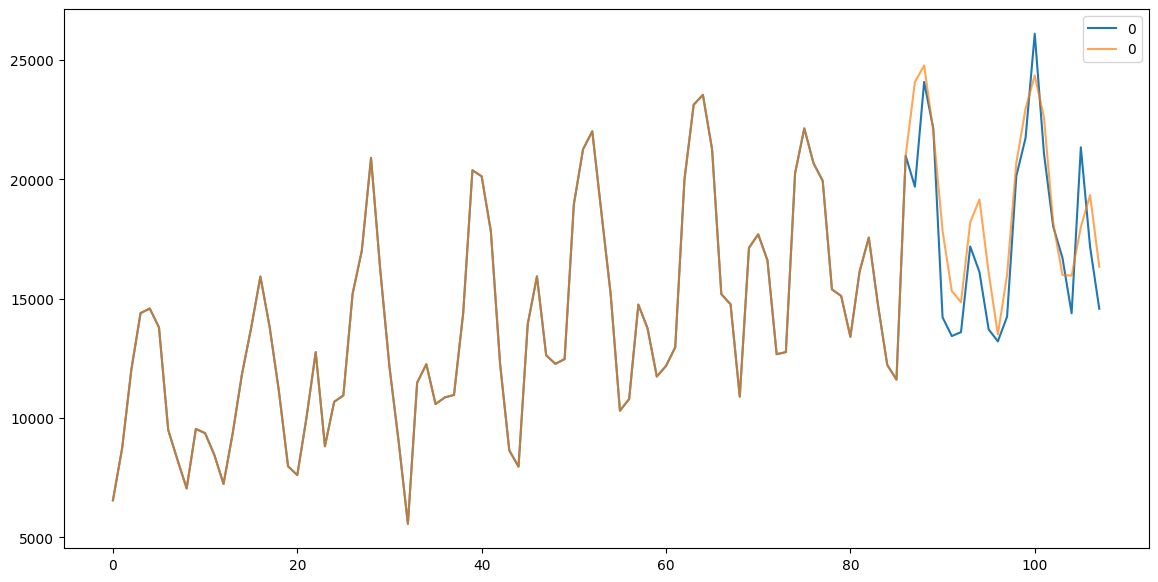

In [17]:
series = read_csv('monthly-car-sales.csv', header=0, index_col=0)
buscar_mejor_solucion(series,"carros")

### Podríamos tratar de usar otra configuruación de entrada, por ejemplo un año (12 meses)

 > 1776.554
 > 1847.614
 > 1842.046
 > 1734.427
 > 1882.738
mlp: 1816.676 RMSE (+/- 53.553)


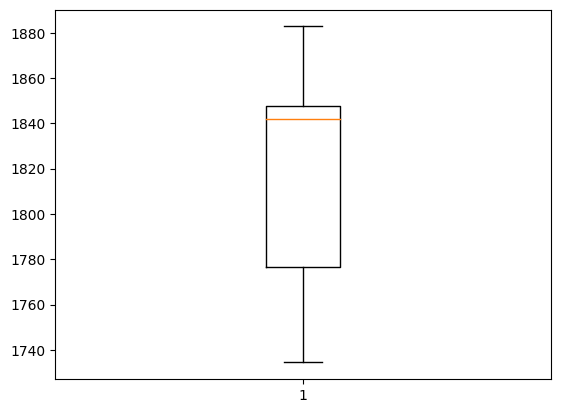

In [18]:
series = read_csv('monthly-car-sales.csv', header=0, index_col=0)
datos = series.values
# división de datos
n_prueba = int(len(datos) * 0.2) # porcentaje utilizao para prueba


# definir config
#config = [24, 500, 100, 100]
config = [[24, 500, 100, 100],[12, 500, 100, 100]]

# búsqueda en malla
resultados, predicciones = evaluacion_iter(datos, config[1], n_prueba)

# resumir resultados
resumir_resultados('mlp', resultados)

# Mostrar Predicciones

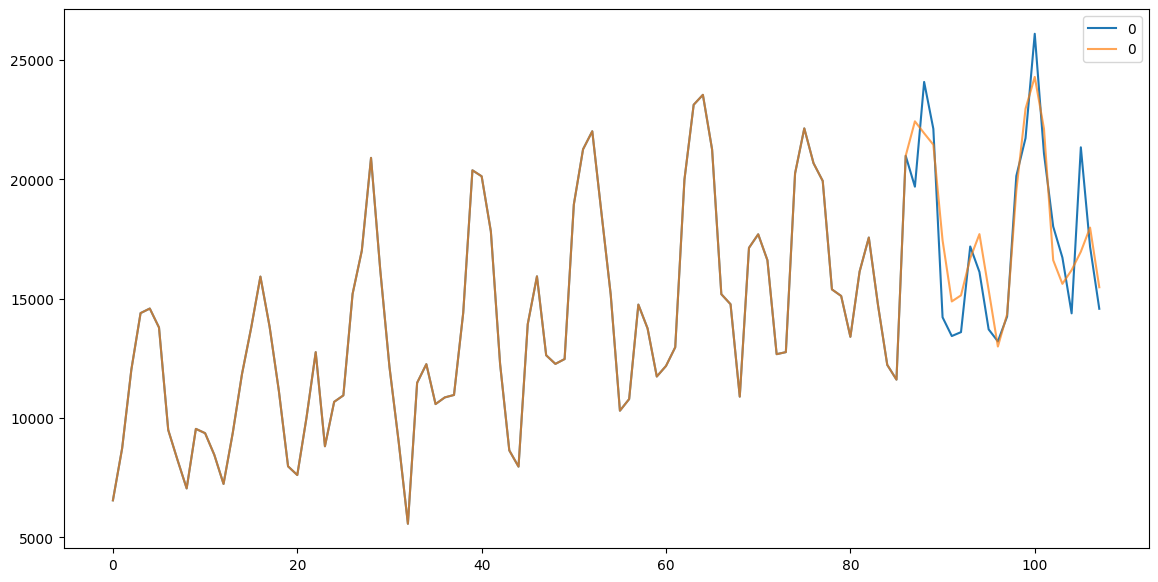

In [19]:
entreno, prueba = division_entreno_prueba(datos,n_prueba)
prediccion = pd.DataFrame(list(entreno.flatten())+np.array(predicciones[0]).flatten().tolist())
ax = pd.DataFrame(datos).plot(label="Original") # datos originales
prediccion.plot(ax=ax, alpha=.7, figsize=(14,7))
plt.show()